In [3]:
import hmr
import bento
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np

bento = hmr.reload(bento)


In [4]:
adata = bento.ds.load_dataset("merfish_raw")
adata = adata[adata.obs["batch"] == "8"]
bento.ut.sync(adata)


Trying to set attribute `._uns` of view, copying.


In [5]:
res = 0.05


In [6]:
bento.tl.flux(adata, method="radius", radius=50, render_resolution=res)
bento.tl.fluxmap(adata, 7, render_resolution=res)


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + cell_raster


  0%|          | 0/15 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + flux_color, flux_embed, flux_genes, flux_variance_ratio, cell_raster, flux


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + fluxmap4_shape, fluxmap7_shape, fluxmap5_shape, fluxmap1_shape, fluxmap2_shape, fluxmap6_shape, fluxmap3_shape


> Goal: plotting should mimic seaborn axes level plotting


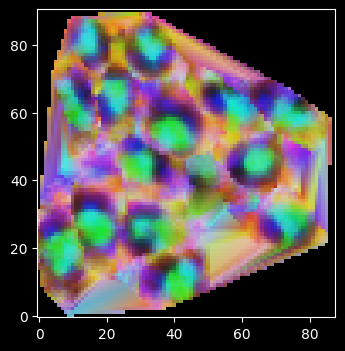

In [57]:
from shapely.geometry import Polygon


def _prepare_points_df(adata, key="points", semantic_vars=None):
    """
    Prepare points DataFrame for plotting. This function will concatenate the appropriate semantic variables as columns to points data.
    """
    points = bento.geo.get_points(adata, key=key)
    cols = list(set(["x", "y", "cell"]))

    if semantic_vars is None or len(semantic_vars) == 0:
        return points[cols]

    cols.extend(semantic_vars)

    # Add semantic variables to points; priority: points, obs, points metadata
    for var in semantic_vars:
        if var in points.columns:
            continue
        elif var in adata.obs.columns:
            points[var] = adata.obs.reindex(points["cell"].values)[var].values
        elif var in adata.uns["point_sets"][key]:
            if len(adata.uns[var].shape) > 1:
                raise ValueError(f"Variable {var} is not 1-dimensional")
            points[var] = adata.uns[var]
        else:
            raise ValueError(f"Variable {var} not found in points or obs")

    return points[cols]


def scatter(
    adata, points_key="points", hue=None, size=None, style=None, ax=None, **kwargs
):
    semantic_vars = list(set([hue, size, style]))
    semantic_vars = [v for v in semantic_vars if v is not None]
    semantic_vars = None if semantic_vars == [] else semantic_vars

    points = _prepare_points_df(adata, key=points_key, semantic_vars=semantic_vars)
    if ax is None:
        ax = plt.gca()

    ax.set_aspect(1)
    ax.set_xlim(points.x.min(), points.x.max())
    ax.set_ylim(points.y.min(), points.y.max())

    scatter_kws = dict(s=2, c="grey", linewidth=0)
    scatter_kws.update(kwargs)

    # Let matplotlib scatter handle color if it's in hex format
    if hue and str(points[hue][0]).startswith("#"):
        scatter_kws["c"] = points[hue]
        hue = None

    sns.scatterplot(
        data=points, x="x", y="y", hue=hue, size=size, style=style, ax=ax, **scatter_kws
    )


def scale_to_data(s, ax):
    M = ax.transData.get_matrix()
    xscale = M[0, 0]
    # has desired_data_width of width
    scaled = (xscale * s) ** 2
    return scaled


def shapes(adata, shape, hue=None, mask_outside=False, ax=None, **kwargs):
    """Plot shapes with GeoSeries plot function."""
    if ax is None:
        ax = plt.gca()

    shapes = gpd.GeoDataFrame(geometry=bento.geo.get_shape(adata, shape))

    if hue:
        shapes[hue] = adata.obs.reset_index()[hue].values
        edge_color = sns.axes_style()["axes.edgecolor"]
        face_color = None  # let GeoDataFrame plot function handle facecolor
    else:
        edge_color = sns.axes_style()["axes.edgecolor"]
        face_color = (0, 0, 0, 0)
    style_kwds = dict(linewidth=0.5, edgecolor=edge_color, facecolor=face_color)
    style_kwds.update(kwargs)
    shapes.plot(ax=ax, column=hue, **style_kwds)

    if mask_outside:
        # get axes limits
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        # Create shapely polygon from axes limits
        axes_poly = gpd.GeoDataFrame(
            geometry=[Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])]
        )
        # axes_poly.overlay(shapes, how="difference").plot(
        #     ax=ax, edgecolor="red", facecolor=sns.axes_style()["axes.facecolor"], zorder=2
        # )

from scipy.interpolate import griddata

def grad(adata, res, color, points_key="cell_raster", ax=None, **kwargs):
    """Plot gradient."""
    points = bento.geo.get_points(adata, key=points_key)
    step = 1 / res
    color = adata.uns[color]
    rgb = np.array([mpl.colors.to_rgb(c) for c in color])

    # Get subplot xy grid bounds
    minx, maxx = points["x"].min(), points["x"].max()
    miny, maxy = points["y"].min(), points["y"].max()

    # Define grid coordinates
    grid_x, grid_y = np.mgrid[
        minx : maxx + step : step,
        miny : maxy + step : step,
    ]

    values = []
    for channel in range(rgb.shape[1]):
        values.append(
            griddata(
                points[["x", "y"]].values,
                rgb[:, channel],
                (grid_x, grid_y),
                method="linear",
                fill_value=0,
            ).T
        )
    img = np.stack(values, axis=-1)
    ax.imshow(img, origin="lower", **kwargs)
    ax.autoscale(False)


with mpl.style.context(style="dark_background"):
    fig, ax = plt.subplots(1, figsize=(4,4))
    grad(adata, res=res, color="flux_color", ax=ax, zorder=1)
    # scatter(adata, ax=ax, zorder=2)
    shapes(adata, "cell_shape", color="pink", zorder=1, mask_outside=False)
    shapes(adata, "nucleus_shape", zorder=1)
